In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

D:\Python\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df = pd.read_csv('training_dataset.csv', delimiter =";")

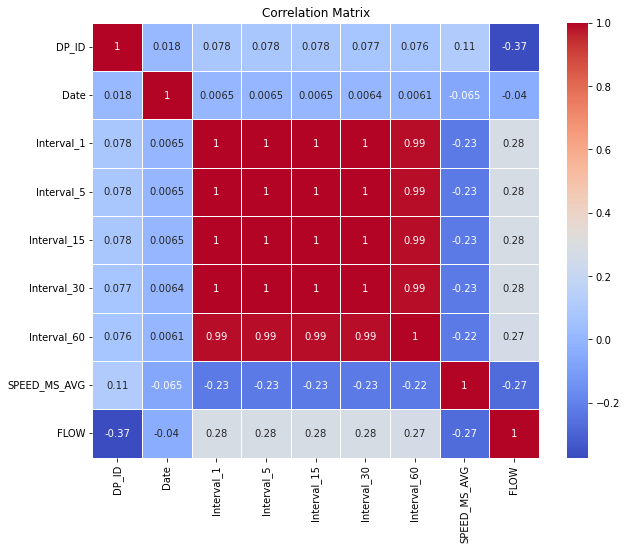

In [5]:
# Calculate the correlation matrix for all columns in the DataFrame 'df'.
corr_matrix = df.corr()
# Sort the correlations between the 'Arrival_delay' column and other columns in descending order.
# This shows the correlation coefficients for each column with respect to 'Arrival_delay'.
correlations_with_arrival_delay = corr_matrix['FLOW'].sort_values(ascending=False)
correlations_with_arrival_delay

import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you already have the 'corr_matrix' containing the correlation values

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# Set the title of the plot
plt.title('Correlation Matrix')
# Show the plot
plt.show()

In [45]:
#Evaluation

eval_df = pd.read_csv('final_evaluation_dataset.csv', delimiter =";")
# print(df.head())
eval_df['Time'] = pd.to_datetime(eval_df['Time'], format='%H:%M:%S').dt.time

eval_df = eval_df[(eval_df['Time'] >= pd.to_datetime('06:00:00').time()) & (eval_df['Time'] <= pd.to_datetime('09:00:00').time())]
# # Convert 'Date' and 'Time' columns to datetime format
eval_df['Date'] = pd.to_datetime(eval_df['Date'], format='%Y%m%d')
eval_df['Time'] = pd.to_datetime(eval_df['Time'], format='%H:%M:%S').dt.time

# Create a new column 'Date_time' by combining 'Date' and 'Time'
eval_df['Date_time'] = pd.to_datetime(eval_df['Date'].astype(str) + ' ' + eval_df['Time'].astype(str), errors='coerce')

# Create df_new with specified features
eval_df_new = pd.DataFrame({
    'Datetime': eval_df['Date_time'],
    'DP_ID': eval_df['DP_ID'],
    'Flow': eval_df['FLOW'],
    'Avg_Speed': eval_df['SPEED_MS_AVG'],
    'Month': eval_df['Date'].dt.month,
    'Week': eval_df['Date'].dt.isocalendar().week,
    'Day': eval_df['Date'].dt.dayofweek + 1,  # Adding 1 to make Monday start from 1
    '1_Min' : eval_df['Interval_1'],
    'Hour': eval_df['Interval_60'] + 1,  # Adding 1 to make it start from 1
    'Half_Hour': eval_df['Interval_30'] * 2 + 1,  # Multiplying by 2 to get half-hour and adding 1
    'Quarter': eval_df['Interval_15'] * 4 + 1,  # Multiplying by 4 to get quarter-hour and adding 1
    '5_mins': eval_df['Interval_5'] * 12 + 1  # Multiplying by 12 to get 5-minute intervals and adding 1
})
eval_df_new.sort_values(by=['Datetime'], inplace=True, ascending=True)
eval_df_new.reset_index(drop=True, inplace=True)
# Sort df_new by DP_ID and Datetime
eval_df_new_sorted = eval_df_new.sort_values(by=['DP_ID', 'Datetime'])

# Create a function to calculate the rolling average for a given DP_ID and time window
def calculate_rolling_average(df, window_size, column_name):
    df[column_name] = df.groupby('DP_ID')['Flow'].transform(lambda x: x.rolling(window=window_size).mean())
    return df

# Create fe_df_new with specified columns
eval_fe_df_new = pd.DataFrame({
    'DP_ID': eval_df_new_sorted['DP_ID'],
    'Month': eval_df_new_sorted['Month'],
    'Week': eval_df_new_sorted['Week'],
    'Day': eval_df_new_sorted['Datetime'].dt.dayofweek + 1,
    'Hour': eval_df_new_sorted['Hour'],
    'Flow': eval_df_new_sorted['Flow'],
    # 'Time': df_new_sorted['Datetime'].dt.time,
    '1_Min': eval_df_new_sorted['1_Min'],
    'Avg_Speed': eval_df_new_sorted['Avg_Speed'],
    'Prev_5Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=5).mean()),
    'Prev_10Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=10).mean()),
    'Prev_15Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=15).mean()),
    'Prev_30Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=30).mean()),
    'Prev_60Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=60).mean())
})
eval_fe_df_new.reset_index(drop=True, inplace=True)
# Fill NaN values in 'Prev_5Min_Avg' with corresponding 'Avg_Speed'
eval_fe_df_new['Prev_5Min_Avg'] = eval_fe_df_new['Prev_5Min_Avg'].fillna(eval_fe_df_new['Flow'])
eval_fe_df_new['Prev_10Min_Avg'] = eval_fe_df_new['Prev_10Min_Avg'].fillna(eval_fe_df_new['Flow'])
eval_fe_df_new['Prev_15Min_Avg'] = eval_fe_df_new['Prev_15Min_Avg'].fillna(eval_fe_df_new['Flow'])
eval_fe_df_new['Prev_30Min_Avg'] = eval_fe_df_new['Prev_30Min_Avg'].fillna(eval_fe_df_new['Flow'])
eval_fe_df_new['Prev_60Min_Avg'] = eval_fe_df_new['Prev_60Min_Avg'].fillna(eval_fe_df_new['Flow'])
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['1_Min', 'Month', 'Week', 'Day', 'Hour']
label_encoder = LabelEncoder()

for col in columns_to_encode:
    eval_fe_df_new[col] = label_encoder.fit_transform(eval_fe_df_new[col]) + 1

round_columns = ['1_Min', 'Prev_5Min_Avg', 'Prev_10Min_Avg','Prev_15Min_Avg','Prev_30Min_Avg','Prev_60Min_Avg']

eval_fe_df_new[round_columns] = eval_fe_df_new[round_columns].round(2)
# Assuming 'Day' column is available in fe_df_new
eval_fe_df_new['weekend'] = eval_fe_df_new['Day'].isin([6, 7]).astype(int)

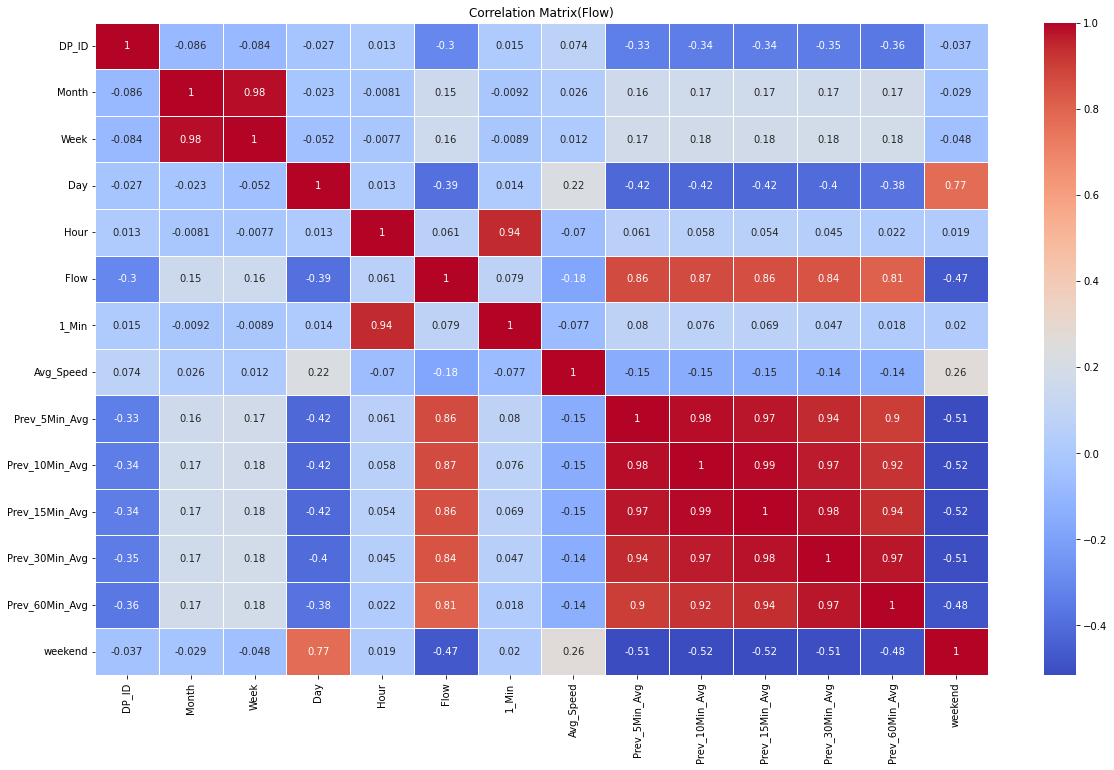

In [47]:
# Calculate the correlation matrix for all columns in the DataFrame 'df'.
corr_matrix_eval = eval_fe_df_new.corr()
# Sort the correlations between the 'Arrival_delay' column and other columns in descending order.
# This shows the correlation coefficients for each column with respect to 'Arrival_delay'.
correlations_with_arrival_delay = corr_matrix_eval['Flow'].sort_values(ascending=False)
correlations_with_arrival_delay

import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you already have the 'corr_matrix' containing the correlation values

# Set the size of the plot
plt.figure(figsize=(20, 12))

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix_eval, annot=True, cmap='coolwarm', linewidths=0.5)
# Set the title of the plot
plt.title('Correlation Matrix(Flow)')
# Show the plot
plt.show()

In [36]:

# Create df_new with specified features
df_new_speed= pd.DataFrame({
    'Datetime': eval_df['Date_time'],
    'DP_ID': eval_df['DP_ID'],
    'Flow': eval_df['FLOW'],
    'Avg_Speed': eval_df['SPEED_MS_AVG'],
    'Month': eval_df['Date'].dt.month,
    'Week': eval_df['Date'].dt.isocalendar().week,
    'Day': eval_df['Date'].dt.dayofweek + 1,  # Adding 1 to make Monday start from 1
    '1_Min' : eval_df['Interval_1'],
    'Hour': eval_df['Interval_60'] + 1,  # Adding 1 to make it start from 1
    'Half_Hour': eval_df['Interval_30'] * 2 + 1,  # Multiplying by 2 to get half-hour and adding 1
    'Quarter': eval_df['Interval_15'] * 4 + 1,  # Multiplying by 4 to get quarter-hour and adding 1
    '5_mins': eval_df['Interval_5'] * 12 + 1  # Multiplying by 12 to get 5-minute intervals and adding 1
})
df_new_speed.sort_values(by=['Datetime'], inplace=True, ascending=True)
df_new_speed.reset_index(drop=True, inplace=True)
# Sort df_new by DP_ID and Datetime
df_new_speedsorted = eval_df_new.sort_values(by=['DP_ID', 'Datetime'])

# Create a function to calculate the rolling average for a given DP_ID and time window
def calculate_rolling_average(df, window_size, column_name):
    df[column_name] = df.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.rolling(window=window_size).mean())
    return df

# Create fe_df_new with specified columns
fe_df_new_speed = pd.DataFrame({
    'DP_ID': df_new_speed['DP_ID'],
    'Month': df_new_speed['Month'],
    'Week': df_new_speed['Week'],
    'Day': df_new_speed['Datetime'].dt.dayofweek + 1,
    'Hour': df_new_speed['Hour'],
    'Flow': df_new_speed['Flow'],
    # 'Time': df_new_sorted['Datetime'].dt.time,
    '1_Min': df_new_speed['1_Min'],
    'Avg_Speed': df_new_speed['Avg_Speed'],
    'Prev_5Min_Avg': df_new_speed.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=5).mean()),
    'Prev_10Min_Avg': df_new_speed.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=10).mean()),
    'Prev_15Min_Avg': df_new_speed.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=15).mean()),
    'Prev_30Min_Avg': df_new_speed.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=30).mean()),
    'Prev_60Min_Avg': df_new_speed.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=60).mean())
})
fe_df_new_speed.reset_index(drop=True, inplace=True)
# Fill NaN values in 'Prev_5Min_Avg' with corresponding 'Avg_Speed'
fe_df_new_speed['Prev_5Min_Avg'] = fe_df_new_speed['Prev_5Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
fe_df_new_speed['Prev_10Min_Avg'] = fe_df_new_speed['Prev_10Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
fe_df_new_speed['Prev_15Min_Avg'] = fe_df_new_speed['Prev_15Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
fe_df_new_speed['Prev_30Min_Avg'] = fe_df_new_speed['Prev_30Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
fe_df_new_speed['Prev_60Min_Avg'] = fe_df_new_speed['Prev_60Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['1_Min', 'Month', 'Week', 'Day', 'Hour']
label_encoder = LabelEncoder()

for col in columns_to_encode:
    fe_df_new_speed[col] = label_encoder.fit_transform(eval_fe_df_new[col]) + 1

round_columns = ['1_Min', 'Prev_5Min_Avg', 'Prev_10Min_Avg','Prev_15Min_Avg','Prev_30Min_Avg','Prev_60Min_Avg']

fe_df_new_speed[round_columns] = fe_df_new_speed[round_columns].round(2)
# Assuming 'Day' column is available in fe_df_new
fe_df_new_speed['weekend'] = fe_df_new_speed['Day'].isin([6, 7]).astype(int)

fe_df_new_speed

,DP_ID,Month,Week,Day,Hour,Flow,1_Min,Avg_Speed,Prev_5Min_Avg,Prev_10Min_Avg,Prev_15Min_Avg,Prev_30Min_Avg,Prev_60Min_Avg,weekend
0,1079,1,1,3,1,16.0,1,19.72,23.71,23.71,23.71,23.71,23.71,0
1,534,1,1,3,1,6.0,2,22.78,24.65,24.65,24.65,24.65,24.65,0
2,351,1,1,3,1,12.0,3,18.63,26.14,26.14,26.14,26.14,26.14,0
3,153,1,1,3,1,8.0,4,23.71,23.60,23.60,23.60,23.60,23.60,0
4,543,1,1,3,1,10.0,5,18.95,23.44,23.44,23.44,23.44,23.44,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423646,751,6,26,4,3,18.0,177,17.93,18.70,18.56,18.45,18.55,18.63,0
423647,539,6,26,4,3,22.0,178,18.92,19.29,19.36,19.39,19.46,19.44,0
423648,1076,6,26,4,3,14.0,179,18.66,18.00,17.91,17.93,17.94,18.04,0
423649,4873,6,26,4,3,10.0,180,17.22,18.00,17.78,17.70,17.34,17.06,0


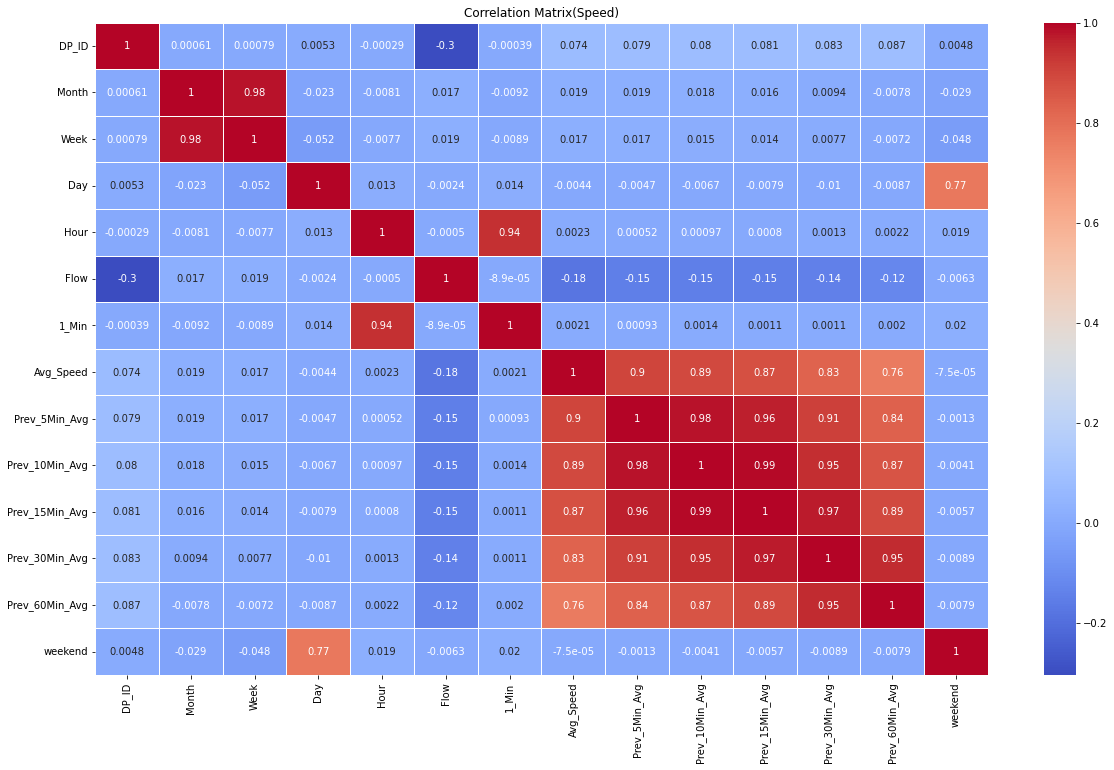

In [43]:
# Calculate the correlation matrix for all columns in the DataFrame 'df'.
corr_matrix_speed = fe_df_new_speed.corr()
# Sort the correlations between the 'Arrival_delay' column and other columns in descending order.
# This shows the correlation coefficients for each column with respect to 'Arrival_delay'.
correlations_with_arrival_delay_speed = corr_matrix_speed['Avg_Speed'].sort_values(ascending=False)
correlations_with_arrival_delay_speed

import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you already have the 'corr_matrix' containing the correlation values

# Set the size of the plot
plt.figure(figsize=(20, 12))

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix_speed, annot=True, cmap='coolwarm', linewidths=0.5)
# Set the title of the plot
plt.title('Correlation Matrix(Speed)')
# Show the plot
plt.show()

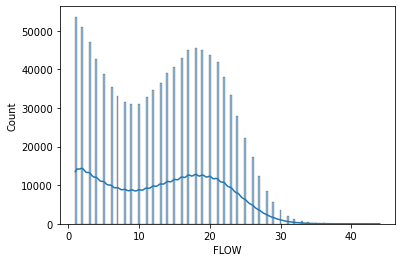

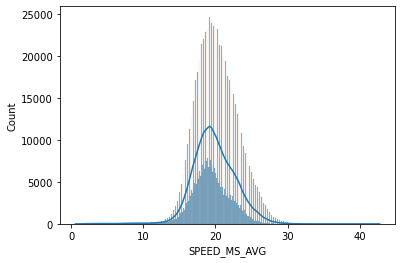

In [26]:
import seaborn as sns
sns.histplot(df['FLOW'], kde=True)
plt.show()

sns.histplot(df['SPEED_MS_AVG'], kde=True)
plt.show()

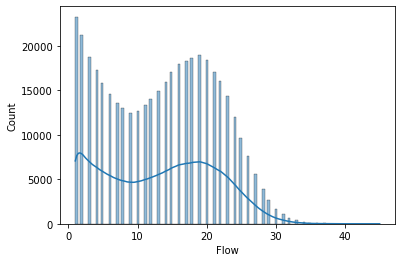

In [28]:
sns.histplot(df['Flow'], kde=True)
plt.show()

In [22]:
# Convert 'Date' and 'Time' columns to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Create a new column 'Date_time' by combining 'Date' and 'Time'
df['Date_time'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')

# Create df_new with specified features
df_new = pd.DataFrame({
    'Datetime': df['Date_time'],
    'DP_ID': df['DP_ID'],
    'Flow': df['FLOW'],
    'Avg_Speed': df['SPEED_MS_AVG'],
    'Month': df['Date'].dt.month,
    'Week': df['Date'].dt.isocalendar().week,
    'Day': df['Date'].dt.dayofweek + 1,  # Adding 1 to make Monday start from 1
    '1_Min' : df['Interval_1'],
    'Hour': df['Interval_60'] + 1,  # Adding 1 to make it start from 1
    'Half_Hour': df['Interval_30'] * 2 + 1,  # Multiplying by 2 to get half-hour and adding 1
    'Quarter': df['Interval_15'] * 4 + 1,  # Multiplying by 4 to get quarter-hour and adding 1
    '5_mins': df['Interval_5'] * 12 + 1  # Multiplying by 12 to get 5-minute intervals and adding 1
})

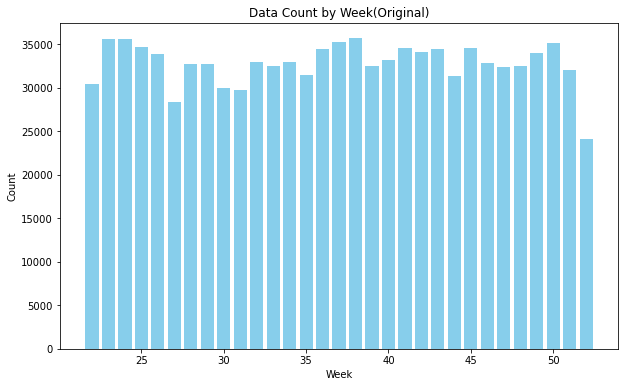

In [23]:
test_week_counts = df_new['Week'].value_counts().sort_index()
test_week_data = pd.DataFrame({'Week': test_week_counts.index, 'Count': test_week_counts.values})

plt.figure(figsize=(10, 6))  
plt.bar(test_week_data['Week'], test_week_data['Count'], color='skyblue')

plt.title('Data Count by Week(Original)')
plt.xlabel('Week')
plt.ylabel('Count')

plt.show()


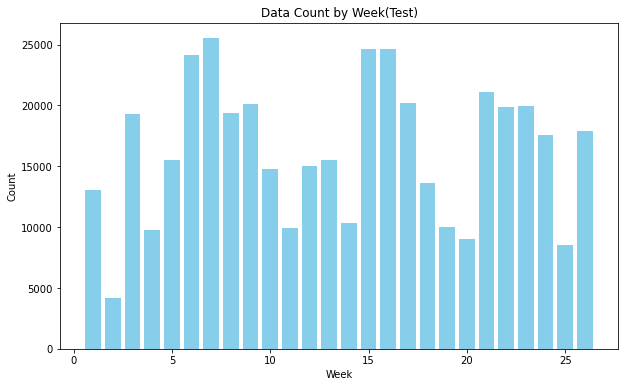

In [21]:
# value
test_week_counts = eval_fe_df_new['Week'].value_counts().sort_index()

# create new dataframe
test_week_data = pd.DataFrame({'Week': test_week_counts.index, 'Count': test_week_counts.values})

# create bar chart
plt.figure(figsize=(10, 6)) 
plt.bar(test_week_data['Week'], test_week_data['Count'], color='skyblue')

plt.title('Data Count by Week(Test)')
plt.xlabel('Week')
plt.ylabel('Count')

plt.show()